🛠 Step 1: Import Libraries

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cuml.manifold import TSNE
import cupy as cp
import os
from tqdm import tqdm


🧠 Step 2: Define Custom ResNet-50 Model


In [1]:
def resnet50_custom(in_channels=3, n_classes=17, dropout=0.5, weights=None):
    model = models.resnet50(weights=weights)
    model.conv1 = nn.Conv2d(
        in_channels,
        64,
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
        bias=False
    )
    model.fc = nn.Sequential(
        nn.BatchNorm1d(2048),
        nn.Dropout(p=dropout),
        nn.Linear(2048, 512, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Dropout(p=dropout),
        nn.Linear(512, 64, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(64),
        nn.Dropout(p=dropout),
        nn.Linear(64, n_classes)
    )
    return model


📂 Step 3: Load Model Weights from .pth File

In [4]:
pth_path = "yichen_model.pth"

checkpoint = torch.load(pth_path, map_location="cuda")

if "state_dict" in checkpoint:
    checkpoint = checkpoint["state_dict"]

clean_state_dict = OrderedDict()
for k, v in checkpoint.items():
    new_k = k.replace("module.", "")
    clean_state_dict[new_k] = v

model = resnet50_custom(in_channels=3, n_classes=17)
model.load_state_dict(clean_state_dict)
model = model.eval().to("cuda:4")

print("✅ Model loaded and ready.")


✅ Model loaded and ready.


🖼 Step 4: Define Dataset Class to Load PNG Images

In [5]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path) if f.endswith('.png')
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]


📦 Step 5: Create DataLoader

In [6]:
folder_path = "data/new"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = UnlabeledImageDataset(folder_path, transform=transform)
loader = DataLoader(dataset, batch_size=512, shuffle=False, pin_memory=True, num_workers=16)


📈 Step 6: Extract Feature Embeddings

In [7]:
model.fc = nn.Sequential(*list(model.fc.children())[:6])

embeddings = []
file_names = []

with torch.no_grad():
    for inputs, paths in tqdm(loader):
        inputs = inputs.to("cuda:4")
        feats = model(inputs)
        embeddings.append(feats.cpu().numpy())
        file_names.extend(paths)

embeddings = np.vstack(embeddings)
print("✅ Feature embeddings extracted.")


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


✅ Feature embeddings extracted.


🔵 Step 7: Run cuML t-SNE on GPU

In [8]:
embeddings_gpu = cp.asarray(embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne_result_gpu = tsne.fit_transform(embeddings_gpu)

tsne_result = cp.asnumpy(tsne_result_gpu)

print("✅ t-SNE completed.")


✅ t-SNE completed.


🖍 Step 8: Visualize t-SNE Output

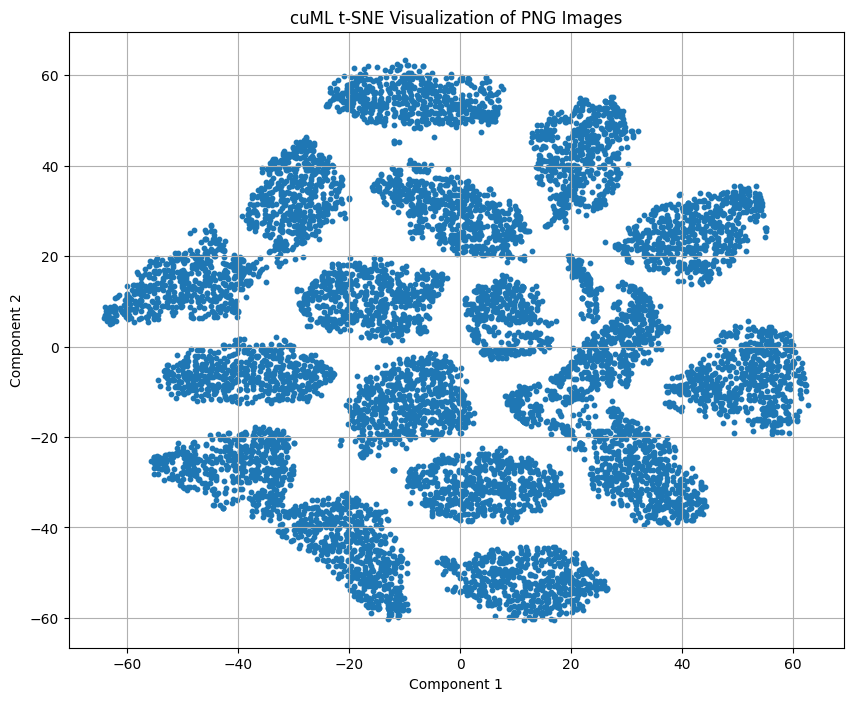

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)
plt.title("cuML t-SNE Visualization of PNG Images")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


In [ ]:
# df = pd.DataFrame(tsne_result, columns=["x", "y"])
# df["filename"] = file_names
# df.to_csv("tsne_output.csv", index=False)

# print("✅ Saved t-SNE results to tsne_output.csv")


🧩 Step 10: Run cuML UMAP on GPU

In [10]:
from cuml import UMAP

# Move embeddings to GPU
embeddings_gpu = cp.asarray(embeddings)

# Run UMAP
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", verbose=1)
umap_result_gpu = umap.fit_transform(embeddings_gpu)

# Move UMAP result back to CPU
umap_result = cp.asnumpy(umap_result_gpu)

print("✅ UMAP completed.")


✅ UMAP completed.


🖍 Step 11: Visualize UMAP Output

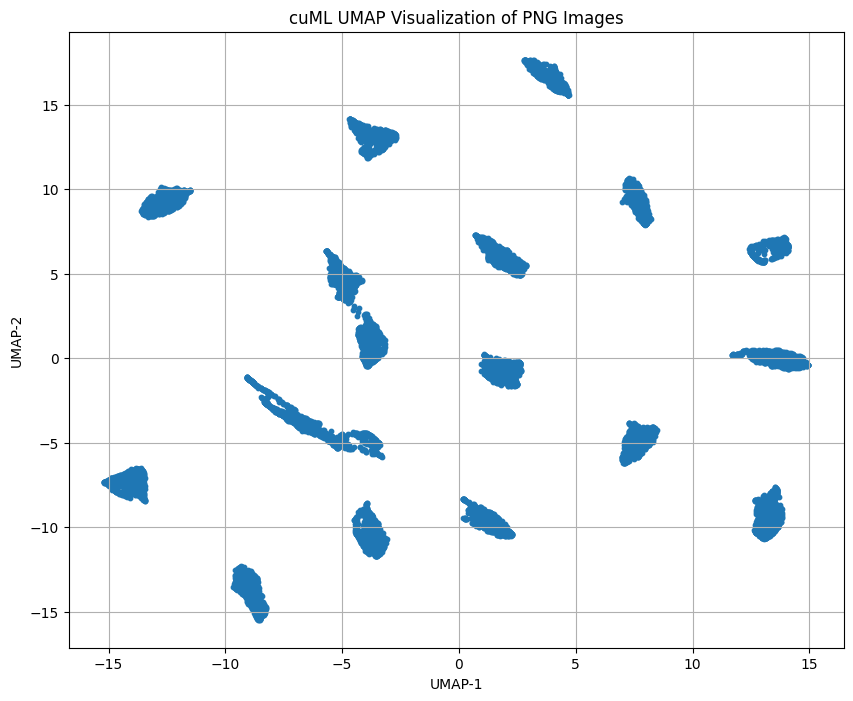

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], s=10)
plt.title("cuML UMAP Visualization of PNG Images")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


💾 Step 12: Save UMAP Coordinates to CSV

In [12]:
# df_umap = pd.DataFrame(umap_result, columns=["UMAP-1", "UMAP-2"])
# df_umap["filename"] = file_names
# df_umap.to_csv("umap_output.csv", index=False)

# print("✅ Saved UMAP results to umap_output.csv")


✅ Saved UMAP results to umap_output.csv


🧠 Step 13: Perform PCA on Embeddings

In [13]:
from sklearn.decomposition import PCA

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

print("✅ PCA completed.")


✅ PCA completed.


🖍 Step 14: Visualize PCA Output

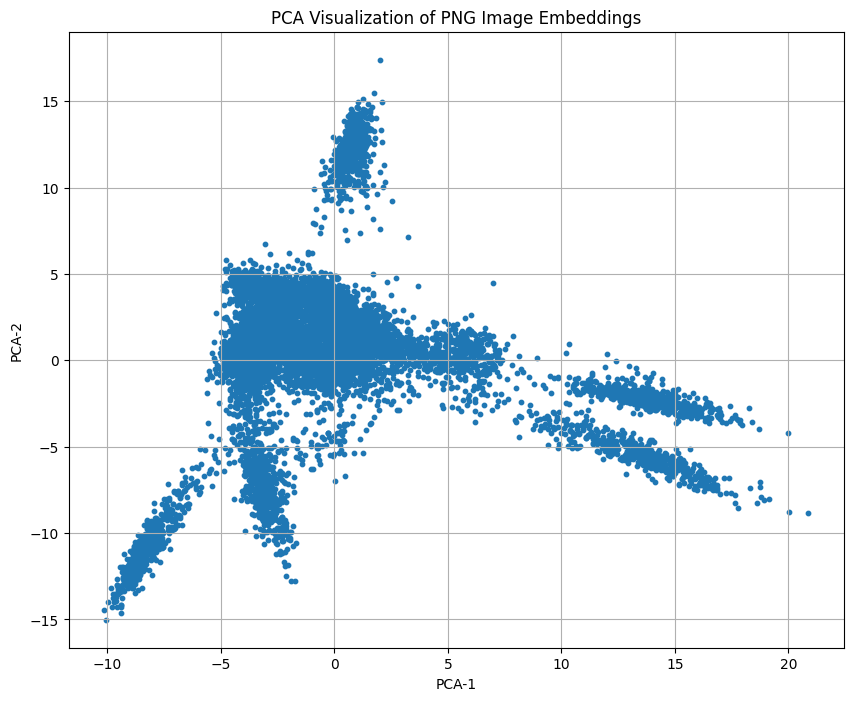

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=10)
plt.title("PCA Visualization of PNG Image Embeddings")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()


💾 Step 15: Save PCA Coordinates to CSV

In [15]:
# df_pca = pd.DataFrame(pca_result, columns=["PCA-1", "PCA-2"])
# df_pca["filename"] = file_names
# df_pca.to_csv("pca_output.csv", index=False)

# print("✅ Saved PCA results to pca_output.csv")


🧩 Step 16: (Already Done) — Clustering with KMeans

In [16]:
from sklearn.cluster import KMeans

# Create 10 clusters (you can adjust number)
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(embeddings)

print("✅ KMeans clustering completed.")


✅ KMeans clustering completed.


🧠 Step 17: Train a Classifier on Top of Embeddings

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split embeddings and pseudo-labels into train/test
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("✅ Classifier trained.")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Classifier trained.
Accuracy: 0.9959

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       217
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       125
           4       0.99      0.99      0.99       476
           5       0.99      1.00      1.00       151
           6       1.00      0.99      0.99        98
           7       0.99      1.00      1.00       119
           8       1.00      1.00      1.00       114
           9       1.00      0.99      0.99        99

    accuracy                           1.00      1967
   macro avg       1.00      1.00      1.00      1967
weighted avg       1.00      1.00      1.00      1967



🧹 Step 18: Anomaly Detection Using Isolation Forest

✅ Anomaly detection completed.


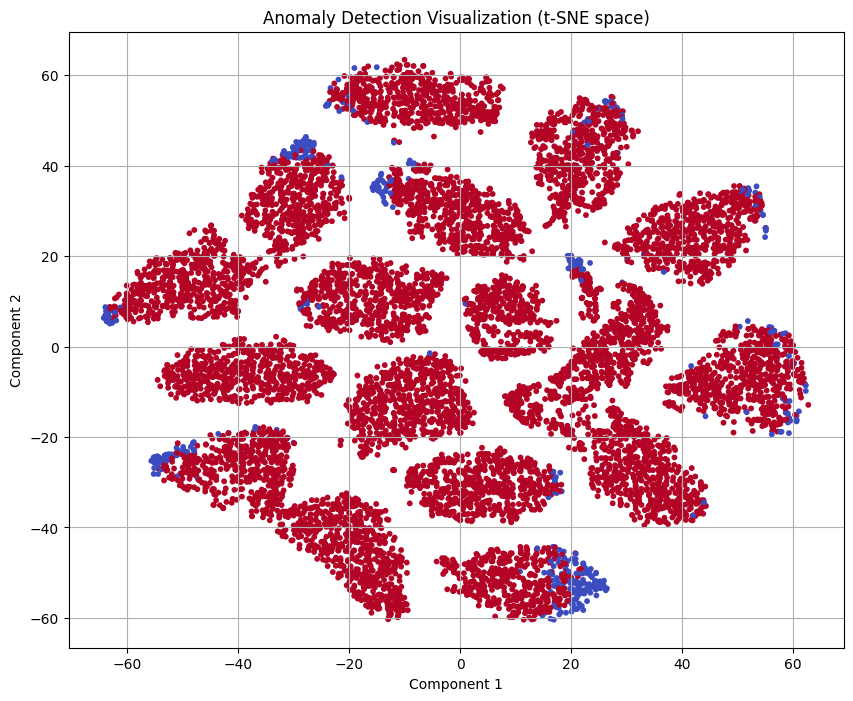

In [18]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso.fit_predict(embeddings)

# anomaly_labels: -1 = anomaly, 1 = normal
print("✅ Anomaly detection completed.")

# Visualize anomalies on t-SNE space
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=anomaly_labels, cmap='coolwarm', s=10)
plt.title('Anomaly Detection Visualization (t-SNE space)')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


🔎 Step 19: Build a Retrieval System with KNN Search

In [19]:
from sklearn.neighbors import NearestNeighbors

# Fit Nearest Neighbor model
knn = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn.fit(embeddings)

# Example: Retrieve similar images for the first image
query_idx = 0
distances, indices = knn.kneighbors([embeddings[query_idx]])

print(f"Query Image: {file_names[query_idx]}")
print("\nTop 5 Similar Images:")
for idx in indices[0]:
    print(file_names[idx])


Query Image: data/output/png/mp-675902_[0, 0, 1].png

Top 5 Similar Images:
data/output/png/mp-675902_[0, 0, 1].png
data/output/png/mp-643277_[0, 0, 1].png
data/output/png/mp-18126_[0, 0, 1].png
data/output/png/mp-1070124_[0, 0, 1].png
data/output/png/mp-29798_[0, 0, 1].png


🗃 Step 20: Retrieval + Display

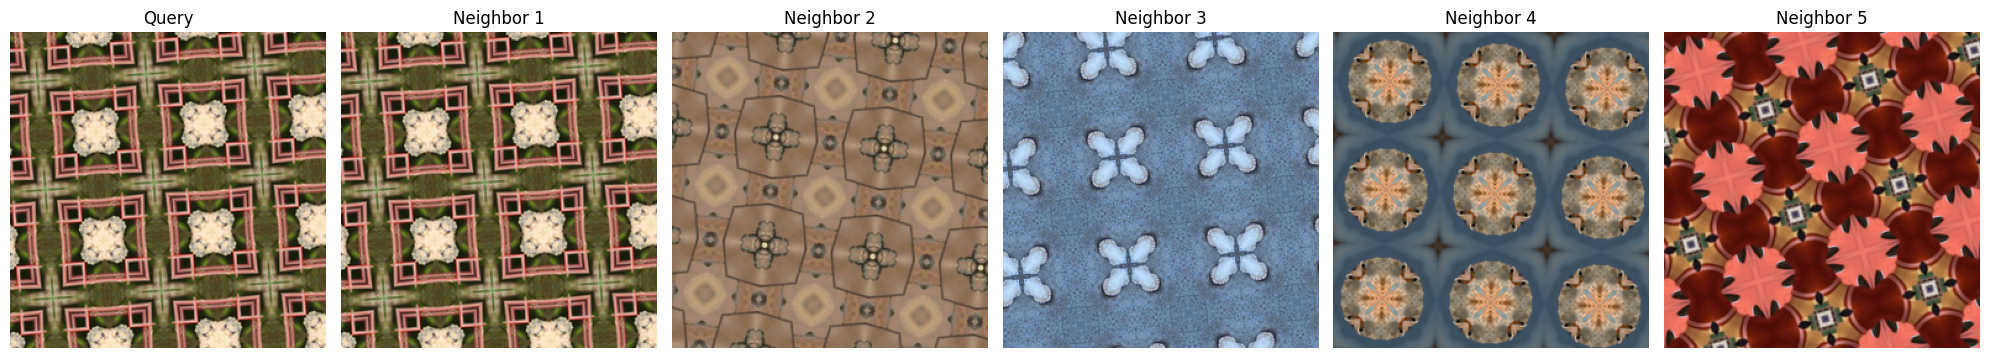

In [20]:
# Visualize query and neighbors
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

# Query Image
img = Image.open(file_names[query_idx]).convert("RGB")
axs[0].imshow(img)
axs[0].set_title("Query")
axs[0].axis("off")

# Retrieved Neighbors
for i, idx in enumerate(indices[0]):
    img = Image.open(file_names[idx]).convert("RGB")
    axs[i+1].imshow(img)
    axs[i+1].set_title(f"Neighbor {i+1}")
    axs[i+1].axis("off")

plt.tight_layout()
plt.show()


🧩 21. Train a LightGBM Classifier on Embeddings

In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Step 1: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42
)

# Step 2: Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Step 3: Check if LightGBM GPU is available
def is_lightgbm_gpu_available():
    try:
        test_params = {
            'objective': 'multiclass',
            'num_class': 2,
            'device': 'gpu',
            'verbosity': -1
        }
        temp_train = lgb.Dataset(np.random.rand(100, 10), label=np.random.randint(0, 2, size=100))
        lgb.train(test_params, temp_train, num_boost_round=1)
        return True
    except:
        return False

use_gpu = is_lightgbm_gpu_available()

# Step 4: Set training parameters
params = {
    'objective': 'multiclass',
    'num_class': len(set(labels)),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'verbosity': -1
}

if use_gpu:
    params['device'] = 'gpu'
    params['gpu_platform_id'] = 0
    params['gpu_device_id'] = 0
    print("✅ LightGBM will use GPU for training.")
else:
    print("⚠️ GPU not available. Falling back to CPU.")

# Step 5: Train the model
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=100,
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(period=10)   # 👈 print every 10 iterations
    ]
)

print("✅ LightGBM model trained successfully.")


✅ LightGBM will use GPU for training.
Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 0.236496
[20]	valid_0's multi_logloss: 0.0572509
[30]	valid_0's multi_logloss: 0.0248538
[40]	valid_0's multi_logloss: 0.0196183
[50]	valid_0's multi_logloss: 0.0208214
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.0191434
✅ LightGBM model trained successfully.


📈 22. Evaluate LightGBM

In [31]:
# Predict
y_pred = lgb_model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test, y_pred_labels))


Accuracy: 0.9933909506863243

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      0.98      0.99       217
           2       0.99      1.00      0.99       350
           3       1.00      1.00      1.00       125
           4       0.99      0.99      0.99       476
           5       0.99      1.00      0.99       151
           6       0.99      0.99      0.99        98
           7       1.00      1.00      1.00       119
           8       1.00      1.00      1.00       114
           9       1.00      1.00      1.00        99

    accuracy                           0.99      1967
   macro avg       0.99      0.99      0.99      1967
weighted avg       0.99      0.99      0.99      1967



🧠 23. Active Learning Simulation

In [ ]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# 1. Initialize
n_initial = int(0.05 * len(X_train))  # Start with 5% labeled data
all_indices = np.arange(len(X_train))
np.random.shuffle(all_indices)

labeled_indices = all_indices[:n_initial]
unlabeled_indices = all_indices[n_initial:]

X_labeled = X_train[labeled_indices]
y_labeled = y_train[labeled_indices]

X_unlabeled = X_train[unlabeled_indices]
y_unlabeled = y_train[unlabeled_indices]  # simulation only

# 2. Active Learning Loop
n_iterations = 10
query_size = int(0.05 * len(X_train))  # select 5% more samples each iteration

accuracies = []

for i in range(n_iterations):
    print(f"🔵 Iteration {i+1}/{n_iterations}")
    
    # Step 3: Train LightGBM model on current labeled set
    train_data = lgb.Dataset(X_labeled, label=y_labeled)
    valid_data = lgb.Dataset(X_test, label=y_test)   # ✅ add validation set here
    
    lgb_model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],   # ✅ important: pass valid_sets for early stopping
        num_boost_round=100,
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=10)
        ]
    )
    
    # Step 4: Evaluate on test set
    y_pred = lgb_model.predict(X_test)
    y_pred_labels = y_pred.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred_labels)
    accuracies.append(acc)
    
    print(f"✅ Test Accuracy after iteration {i+1}: {acc:.4f}")
    
    # Step 5: If no more unlabeled data, break
    if len(X_unlabeled) == 0:
        print("⚠️ No more unlabeled data left to query.")
        break

    # Step 6: Find most uncertain samples
    preds_unlabeled = lgb_model.predict(X_unlabeled)
    uncertainty = 1 - np.max(preds_unlabeled, axis=1)
    
    # Select the most uncertain samples
    query_indices = np.argsort(uncertainty)[-query_size:]

    # Step 7: Move queried samples from unlabeled -> labeled
    new_labeled = X_unlabeled[query_indices]
    new_labels = y_unlabeled[query_indices]

    X_labeled = np.concatenate([X_labeled, new_labeled])
    y_labeled = np.concatenate([y_labeled, new_labels])

    # Remove from unlabeled pool
    mask = np.ones(len(X_unlabeled), dtype=bool)
    mask[query_indices] = False
    X_unlabeled = X_unlabeled[mask]
    y_unlabeled = y_unlabeled[mask]

🔵 Iteration 1/10
Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 0.302966
[20]	valid_0's multi_logloss: 0.111166
[30]	valid_0's multi_logloss: 0.0734363
[40]	valid_0's multi_logloss: 0.0618471
[50]	valid_0's multi_logloss: 0.0571874
[60]	valid_0's multi_logloss: 0.0551611
[70]	valid_0's multi_logloss: 0.0550417
[80]	valid_0's multi_logloss: 0.0557561
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.0549292
✅ Test Accuracy after iteration 1: 0.9853
🔵 Iteration 2/10
Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 0.266913
[20]	valid_0's multi_logloss: 0.0760505
[30]	valid_0's multi_logloss: 0.0386508
[40]	valid_0's multi_logloss: 0.0311261
[50]	valid_0's multi_logloss: 0.030303
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.0301169
✅ Test Accuracy after iteration 2: 0.9863
🔵 Iteration 3/10
Training until validation scores don't improve for 10 rounds
[10]	valid_0's m

📈 24. Plot Accuracy Improvement over Active Learning Iterations

In [ ]:
# 8. Plot Accuracy over Iterations
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.title("Active Learning: Accuracy over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()
